# Method 8 - Best Ideas High Minus Low Concentration

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Herfindahl

inst_data['target_sq'] = inst_data['target'] ** 2
herf = inst_data.groupby(['datadate', 'institution_id'])['target_sq'].sum().rename('herf').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Use Raw Weight

valid_data['adj_target'] = valid_data['target']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Herf

best_ideas = best_ideas.merge(herf)
best_ideas['herf_pct'] = best_ideas.groupby('datadate')['herf'].rank(pct=True)
low_ideas = best_ideas[best_ideas['herf_pct'] < (1 / 3)]
high_ideas = best_ideas[best_ideas['herf_pct'] > (2 / 3)]

# Weight the best ideas equally

low_ideas['target'] = 1 / low_ideas.groupby('datadate')['institution_id'].transform('count')
high_ideas['target'] = 1 / high_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
low_w = weights.Weights(low_ideas)
high_w = weights.Weights(high_ideas)

%store -r r

low_p = portfolio.DailyPortfolio(low_w, r, end_date='2018-12-31')
high_p = portfolio.DailyPortfolio(high_w, r, end_date='2018-12-31')

monthly_return = (high_p.port_return - low_p.port_return).loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return.name = 'port_return'

## Plot Performance

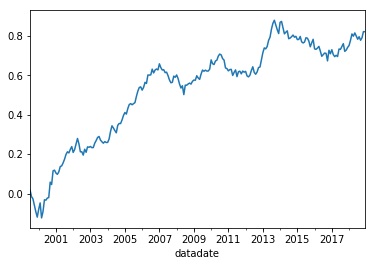

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31   -0.119974
2000-12-31    0.271022
2001-12-31    0.106927
2002-12-31   -0.002936
2003-12-31    0.019778
2004-12-31    0.108790
2005-12-31    0.104018
2006-12-31    0.055904
2007-12-31   -0.023108
2008-12-31   -0.012853
2009-12-31    0.039395
2010-12-31    0.001731
2011-12-31   -0.011193
2012-12-31    0.038044
2013-12-31    0.080180
2014-12-31   -0.007757
2015-12-31   -0.008444
2016-12-31   -0.041122
2017-12-31    0.018983
2018-12-31    0.045690
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     12.17
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.46e-09
Time:                        06:41:24   Log-Likelihood:                 647.27
No. Observations:                 234   AIC:                            -1285.
Df Residuals:                     229   BIC:                            -1267.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      2.743      0.007       0.001       0.005
mktrf         -0.1317      0.029     -4.590      0.000      -0.188      -0.075
me             0.1401      0.033      4.197      0.000       0.074       0.206
ia             0.1287      0.051      2.536      0.012       0.029       0.229
roe           -0.1240      0.043     -2.856      0.005      -0.210      -0.038
==============================================================================
Omnibus:                       25.790   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               83.495
Skew:                           0.370   Prob(JB):                     7.40e-19
Kurtosis:                       5.831   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     6.808
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.40e-05
Time:                        06:41:24   Log-Likelihood:                 647.27
No. Observations:                 234   AIC:                            -1285.
Df Residuals:                     229   BIC:                            -1267.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      2.515      0.012       0.001       0.005
mktrf         -0.1317      0.046     -2.860      0.004      -0.222      -0.041
me             0.1401      0.029      4.845      0.000       0.083       0.197
ia             0.1287      0.077      1.663      0.096      -0.023       0.280
roe           -0.1240      0.055     -2.243      0.025      -0.232      -0.016
==============================================================================
Omnibus:                       25.790   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               83.495
Skew:                           0.370   Prob(JB):                     7.40e-19
Kurtosis:                       5.831   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     7.520
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.04e-05
Time:                        06:41:24   Log-Likelihood:                 647.27
No. Observations:                 234   AIC:                            -1285.
Df Residuals:                     229   BIC:                            -1267.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      2.518      0.012       0.001       0.005
mktrf         -0.1317      0.044     -2.994      0.003      -0.218      -0.045
me             0.1401      0.030      4.738      0.000       0.082       0.198
ia             0.1287      0.084      1.528      0.127      -0.036       0.294
roe           -0.1240      0.046     -2.726      0.006      -0.213      -0.035
==============================================================================
Omnibus:                       25.790   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               83.495
Skew:                           0.370   Prob(JB):                     7.40e-19
Kurtosis:                       5.831   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     10.23
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.34e-09
Time:                        06:41:24   Log-Likelihood:                 648.40
No. Observations:                 234   AIC:                            -1285.
Df Residuals:                     228   BIC:                            -1264.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      2.747      0.006       0.001       0.005
mktrf         -0.1170      0.029     -4.080      0.000      -0.174      -0.061
smb            0.1051      0.038      2.776      0.006       0.030       0.180
hml            0.0882      0.045      1.978      0.049       0.000       0.176
rmw           -0.1434      0.050     -2.842      0.005      -0.243      -0.044
cma            0.1192      0.064      1.858      0.064      -0.007       0.246
==============================================================================
Omnibus:                       24.162   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               77.951
Skew:                           0.330   Prob(JB):                     1.18e-17
Kurtosis:                       5.750   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     4.848
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           0.000311
Time:                        06:41:24   Log-Likelihood:                 648.40
No. Observations:                 234   AIC:                            -1285.
Df Residuals:                     228   BIC:                            -1264.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      2.666      0.008       0.001       0.005
mktrf         -0.1170      0.040     -2.926      0.003      -0.195      -0.039
smb            0.1051      0.031      3.394      0.001       0.044       0.166
hml            0.0882      0.035      2.524      0.012       0.020       0.157
rmw           -0.1434      0.058     -2.452      0.014      -0.258      -0.029
cma            0.1192      0.082      1.450      0.147      -0.042       0.280
==============================================================================
Omnibus:                       24.162   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               77.951
Skew:                           0.330   Prob(JB):                     1.18e-17
Kurtosis:                       5.750   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     6.064
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.71e-05
Time:                        06:41:24   Log-Likelihood:                 648.40
No. Observations:                 234   AIC:                            -1285.
Df Residuals:                     228   BIC:                            -1264.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      2.684      0.007       0.001       0.005
mktrf         -0.1170      0.040     -2.942      0.003      -0.195      -0.039
smb            0.1051      0.032      3.322      0.001       0.043       0.167
hml            0.0882      0.033      2.665      0.008       0.023       0.153
rmw           -0.1434      0.050     -2.871      0.004      -0.241      -0.045
cma            0.1192      0.087      1.368      0.171      -0.052       0.290
==============================================================================
Omnibus:                       24.162   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               77.951
Skew:                           0.330   Prob(JB):                     1.18e-17
Kurtosis:                       5.750   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     11.61
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.35e-08
Time:                        06:41:24   Log-Likelihood:                 646.31
No. Observations:                 234   AIC:                            -1283.
Df Residuals:                     229   BIC:                            -1265.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      2.782      0.006       0.001       0.005
mktrf         -0.1258      0.027     -4.742      0.000      -0.178      -0.074
smb            0.1733      0.033      5.233      0.000       0.108       0.239
hml            0.1025      0.033      3.116      0.002       0.038       0.167
umd           -0.0670      0.022     -3.105      0.002      -0.110      -0.024
==============================================================================
Omnibus:                       22.721   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.498
Skew:                           0.167   Prob(JB):                     6.07e-20
Kurtosis:                       5.994   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     3.552
Date:                Tue, 28 Apr 2020   Prob (F-statistic):            0.00781
Time:                        06:41:24   Log-Likelihood:                 646.31
No. Observations:                 234   AIC:                            -1283.
Df Residuals:                     229   BIC:                            -1265.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      2.721      0.007       0.001       0.005
mktrf         -0.1258      0.047     -2.687      0.007      -0.218      -0.034
smb            0.1733      0.057      3.051      0.002       0.062       0.285
hml            0.1025      0.037      2.777      0.005       0.030       0.175
umd           -0.0670      0.029     -2.347      0.019      -0.123      -0.011
==============================================================================
Omnibus:                       22.721   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.498
Skew:                           0.167   Prob(JB):                     6.07e-20
Kurtosis:                       5.994   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     3.650
Date:                Tue, 28 Apr 2020   Prob (F-statistic):            0.00664
Time:                        06:41:24   Log-Likelihood:                 646.31
No. Observations:                 234   AIC:                            -1283.
Df Residuals:                     229   BIC:                            -1265.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      2.636      0.008       0.001       0.005
mktrf         -0.1258      0.050     -2.537      0.011      -0.223      -0.029
smb            0.1733      0.053      3.256      0.001       0.069       0.278
hml            0.1025      0.040      2.566      0.010       0.024       0.181
umd           -0.0670      0.026     -2.582      0.010      -0.118      -0.016
==============================================================================
Omnibus:                       22.721   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.498
Skew:                           0.167   Prob(JB):                     6.07e-20
Kurtosis:                       5.994   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     6.346
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           0.000119
Time:                        06:41:24   Log-Likelihood:                 310.56
No. Observations:                 120   AIC:                            -611.1
Df Residuals:                     115   BIC:                            -597.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.002      1.756      0.082      -0.000       0.007
mktrf         -0.1416      0.048     -2.957      0.004      -0.236      -0.047
me             0.1192      0.047      2.520      0.013       0.025       0.213
ia             0.1834      0.074      2.476      0.015       0.037       0.330
roe           -0.1306      0.066     -1.992      0.049      -0.260      -0.001
==============================================================================
Omnibus:                        9.675   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               17.948
Skew:                           0.269   Prob(JB):                     0.000127
Kurtosis:                       4.817   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     2.230
Date:                Tue, 28 Apr 2020   Prob (F-statistic):             0.0700
Time:                        06:41:24   Log-Likelihood:                 310.56
No. Observations:                 120   AIC:                            -611.1
Df Residuals:                     115   BIC:                            -597.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.002      1.651      0.099      -0.001       0.007
mktrf         -0.1416      0.084     -1.690      0.091      -0.306       0.023
me             0.1192      0.040      2.962      0.003       0.040       0.198
ia             0.1834      0.094      1.941      0.052      -0.002       0.369
roe           -0.1306      0.087     -1.504      0.133      -0.301       0.040
==============================================================================
Omnibus:                        9.675   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               17.948
Skew:                           0.269   Prob(JB):                     0.000127
Kurtosis:                       4.817   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     2.450
Date:                Tue, 28 Apr 2020   Prob (F-statistic):             0.0501
Time:                        06:41:24   Log-Likelihood:                 310.56
No. Observations:                 120   AIC:                            -611.1
Df Residuals:                     115   BIC:                            -597.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.002      1.622      0.105      -0.001       0.007
mktrf         -0.1416      0.080     -1.776      0.076      -0.298       0.015
me             0.1192      0.040      2.975      0.003       0.041       0.198
ia             0.1834      0.098      1.867      0.062      -0.009       0.376
roe           -0.1306      0.071     -1.844      0.065      -0.269       0.008
==============================================================================
Omnibus:                        9.675   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               17.948
Skew:                           0.269   Prob(JB):                     0.000127
Kurtosis:                       4.817   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     6.349
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.09e-05
Time:                        06:41:24   Log-Likelihood:                 313.33
No. Observations:                 120   AIC:                            -614.7
Df Residuals:                     114   BIC:                            -597.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.002      1.985      0.050    7.67e-06       0.007
mktrf         -0.1467      0.050     -2.960      0.004      -0.245      -0.049
smb            0.0559      0.056      0.996      0.321      -0.055       0.167
hml            0.1488      0.069      2.164      0.033       0.013       0.285
rmw           -0.2154      0.081     -2.655      0.009      -0.376      -0.055
cma            0.1450      0.089      1.632      0.105      -0.031       0.321
==============================================================================
Omnibus:                       10.215   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               18.975
Skew:                           0.299   Prob(JB):                     7.58e-05
Kurtosis:                       4.854   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     1.678
Date:                Tue, 28 Apr 2020   Prob (F-statistic):              0.146
Time:                        06:41:24   Log-Likelihood:                 313.33
No. Observations:                 120   AIC:                            -614.7
Df Residuals:                     114   BIC:                            -597.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.002      2.007      0.045    8.38e-05       0.007
mktrf         -0.1467      0.075     -1.966      0.049      -0.293      -0.000
smb            0.0559      0.035      1.598      0.110      -0.013       0.124
hml            0.1488      0.061      2.450      0.014       0.030       0.268
rmw           -0.2154      0.097     -2.209      0.027      -0.406      -0.024
cma            0.1450      0.086      1.678      0.093      -0.024       0.314
==============================================================================
Omnibus:                       10.215   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               18.975
Skew:                           0.299   Prob(JB):                     7.58e-05
Kurtosis:                       4.854   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     2.012
Date:                Tue, 28 Apr 2020   Prob (F-statistic):             0.0822
Time:                        06:41:24   Log-Likelihood:                 313.33
No. Observations:                 120   AIC:                            -614.7
Df Residuals:                     114   BIC:                            -597.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.002      2.069      0.039       0.000       0.007
mktrf         -0.1467      0.071     -2.054      0.040      -0.287      -0.007
smb            0.0559      0.033      1.703      0.089      -0.008       0.120
hml            0.1488      0.053      2.785      0.005       0.044       0.254
rmw           -0.2154      0.081     -2.666      0.008      -0.374      -0.057
cma            0.1450      0.091      1.593      0.111      -0.033       0.323
==============================================================================
Omnibus:                       10.215   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               18.975
Skew:                           0.299   Prob(JB):                     7.58e-05
Kurtosis:                       4.854   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     7.409
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.40e-05
Time:                        06:41:24   Log-Likelihood:                 312.35
No. Observations:                 120   AIC:                            -614.7
Df Residuals:                     115   BIC:                            -600.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.002      1.681      0.096      -0.001       0.006
mktrf         -0.1576      0.042     -3.792      0.000      -0.240      -0.075
smb            0.1814      0.047      3.833      0.000       0.088       0.275
hml            0.1309      0.047      2.761      0.007       0.037       0.225
umd           -0.0898      0.029     -3.071      0.003      -0.148      -0.032
==============================================================================
Omnibus:                       10.026   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               24.323
Skew:                           0.051   Prob(JB):                     5.23e-06
Kurtosis:                       5.203   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     4.104
Date:                Tue, 28 Apr 2020   Prob (F-statistic):            0.00381
Time:                        06:41:24   Log-Likelihood:                 312.35
No. Observations:                 120   AIC:                            -614.7
Df Residuals:                     115   BIC:                            -600.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.002      1.839      0.066      -0.000       0.006
mktrf         -0.1576      0.067     -2.353      0.019      -0.289      -0.026
smb            0.1814      0.089      2.044      0.041       0.007       0.355
hml            0.1309      0.038      3.452      0.001       0.057       0.205
umd           -0.0898      0.035     -2.570      0.010      -0.158      -0.021
==============================================================================
Omnibus:                       10.026   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               24.323
Skew:                           0.051   Prob(JB):                     5.23e-06
Kurtosis:                       5.203   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     4.279
Date:                Tue, 28 Apr 2020   Prob (F-statistic):            0.00290
Time:                        06:41:24   Log-Likelihood:                 312.35
No. Observations:                 120   AIC:                            -614.7
Df Residuals:                     115   BIC:                            -600.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.002      1.758      0.079      -0.000       0.006
mktrf         -0.1576      0.069     -2.276      0.023      -0.293      -0.022
smb            0.1814      0.085      2.146      0.032       0.016       0.347
hml            0.1309      0.039      3.368      0.001       0.055       0.207
umd           -0.0898      0.032     -2.804      0.005      -0.153      -0.027
==============================================================================
Omnibus:                       10.026   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               24.323
Skew:                           0.051   Prob(JB):                     5.23e-06
Kurtosis:                       5.203   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     9.247
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.80e-06
Time:                        06:41:24   Log-Likelihood:                 357.93
No. Observations:                 114   AIC:                            -705.9
Df Residuals:                     109   BIC:                            -692.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.536      0.013       0.001       0.005
mktrf         -0.1178      0.031     -3.740      0.000      -0.180      -0.055
me             0.1775      0.049      3.650      0.000       0.081       0.274
ia            -0.0733      0.067     -1.086      0.280      -0.207       0.060
roe           -0.2151      0.059     -3.628      0.000      -0.333      -0.098
==============================================================================
Omnibus:                        0.021   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.989   Jarque-Bera (JB):                0.032
Skew:                           0.017   Prob(JB):                        0.984
Kurtosis:                       2.925   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     9.737
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.01e-07
Time:                        06:41:24   Log-Likelihood:                 357.93
No. Observations:                 114   AIC:                            -705.9
Df Residuals:                     109   BIC:                            -692.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.097      0.036       0.000       0.005
mktrf         -0.1178      0.028     -4.245      0.000      -0.172      -0.063
me             0.1775      0.044      4.072      0.000       0.092       0.263
ia            -0.0733      0.066     -1.109      0.267      -0.203       0.056
roe           -0.2151      0.067     -3.213      0.001      -0.346      -0.084
==============================================================================
Omnibus:                        0.021   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.989   Jarque-Bera (JB):                0.032
Skew:                           0.017   Prob(JB):                        0.984
Kurtosis:                       2.925   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     14.92
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.42e-10
Time:                        06:41:24   Log-Likelihood:                 357.93
No. Observations:                 114   AIC:                            -705.9
Df Residuals:                     109   BIC:                            -692.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      1.893      0.058   -9.55e-05       0.006
mktrf         -0.1178      0.027     -4.438      0.000      -0.170      -0.066
me             0.1775      0.046      3.863      0.000       0.087       0.268
ia            -0.0733      0.063     -1.164      0.244      -0.197       0.050
roe           -0.2151      0.074     -2.909      0.004      -0.360      -0.070
==============================================================================
Omnibus:                        0.021   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.989   Jarque-Bera (JB):                0.032
Skew:                           0.017   Prob(JB):                        0.984
Kurtosis:                       2.925   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     7.419
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.14e-06
Time:                        06:41:24   Log-Likelihood:                 358.11
No. Observations:                 114   AIC:                            -704.2
Df Residuals:                     108   BIC:                            -687.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      2.327      0.022       0.000       0.005
mktrf         -0.0976      0.030     -3.239      0.002      -0.157      -0.038
smb            0.1650      0.049      3.374      0.001       0.068       0.262
hml           -0.0465      0.062     -0.746      0.457      -0.170       0.077
rmw           -0.2739      0.076     -3.586      0.001      -0.425      -0.123
cma            0.0188      0.097      0.194      0.846      -0.173       0.211
==============================================================================
Omnibus:                        0.474   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.789   Jarque-Bera (JB):                0.624
Skew:                          -0.071   Prob(JB):                        0.732
Kurtosis:                       2.666   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     9.892
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.30e-08
Time:                        06:41:24   Log-Likelihood:                 358.11
No. Observations:                 114   AIC:                            -704.2
Df Residuals:                     108   BIC:                            -687.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      2.091      0.037       0.000       0.005
mktrf         -0.0976      0.030     -3.211      0.001      -0.157      -0.038
smb            0.1650      0.048      3.429      0.001       0.071       0.259
hml           -0.0465      0.064     -0.729      0.466      -0.172       0.079
rmw           -0.2739      0.082     -3.349      0.001      -0.434      -0.114
cma            0.0188      0.103      0.183      0.855      -0.182       0.220
==============================================================================
Omnibus:                        0.474   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.789   Jarque-Bera (JB):                0.624
Skew:                          -0.071   Prob(JB):                        0.732
Kurtosis:                       2.666   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     11.14
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.14e-08
Time:                        06:41:24   Log-Likelihood:                 358.11
No. Observations:                 114   AIC:                            -704.2
Df Residuals:                     108   BIC:                            -687.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      1.959      0.050   -1.21e-06       0.005
mktrf         -0.0976      0.034     -2.858      0.004      -0.165      -0.031
smb            0.1650      0.047      3.497      0.000       0.073       0.258
hml           -0.0465      0.052     -0.899      0.369      -0.148       0.055
rmw           -0.2739      0.084     -3.262      0.001      -0.439      -0.109
cma            0.0188      0.088      0.213      0.831      -0.155       0.192
==============================================================================
Omnibus:                        0.474   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.789   Jarque-Bera (JB):                0.624
Skew:                          -0.071   Prob(JB):                        0.732
Kurtosis:                       2.666   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     5.201
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           0.000715
Time:                        06:41:24   Log-Likelihood:                 351.24
No. Observations:                 114   AIC:                            -692.5
Df Residuals:                     109   BIC:                            -678.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      1.765      0.080      -0.000       0.004
mktrf         -0.0778      0.032     -2.459      0.016      -0.141      -0.015
smb            0.2201      0.049      4.460      0.000       0.122       0.318
hml            0.0023      0.051      0.046      0.963      -0.098       0.103
umd           -0.0139      0.038     -0.362      0.718      -0.090       0.062
==============================================================================
Omnibus:                        0.012   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.994   Jarque-Bera (JB):                0.033
Skew:                          -0.005   Prob(JB):                        0.984
Kurtosis:                       2.918   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     4.937
Date:                Tue, 28 Apr 2020   Prob (F-statistic):            0.00107
Time:                        06:41:24   Log-Likelihood:                 351.24
No. Observations:                 114   AIC:                            -692.5
Df Residuals:                     109   BIC:                            -678.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      1.525      0.127      -0.001       0.005
mktrf         -0.0778      0.031     -2.504      0.012      -0.139      -0.017
smb            0.2201      0.053      4.166      0.000       0.117       0.324
hml            0.0023      0.052      0.045      0.964      -0.100       0.104
umd           -0.0139      0.042     -0.330      0.742      -0.096       0.069
==============================================================================
Omnibus:                        0.012   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.994   Jarque-Bera (JB):                0.033
Skew:                          -0.005   Prob(JB):                        0.984
Kurtosis:                       2.918   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     6.698
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.38e-05
Time:                        06:41:24   Log-Likelihood:                 351.24
No. Observations:                 114   AIC:                            -692.5
Df Residuals:                     109   BIC:                            -678.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      1.394      0.163      -0.001       0.005
mktrf         -0.0778      0.033     -2.389      0.017      -0.142      -0.014
smb            0.2201      0.053      4.123      0.000       0.115       0.325
hml            0.0023      0.044      0.054      0.957      -0.083       0.088
umd           -0.0139      0.045     -0.309      0.757      -0.102       0.074
==============================================================================
Omnibus:                        0.012   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.994   Jarque-Bera (JB):                0.033
Skew:                          -0.005   Prob(JB):                        0.984
Kurtosis:                       2.918   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""